In [1]:
# pip install jupyter
# pip install qiskit
# pip install qiskit-experiments
# pip install qiskit-aer
# pip install scikit-learn
# pip install pandas
# pip install matplotlib
# pip install pylatexenc
# pip install q-alchemy-sdk-py[qiskit]

### Get the state vector

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml

digits = fetch_openml('optdigits', version=1, parser="auto")

one: np.ndarray = digits.data[digits.target == "1"].iloc[1].to_numpy()
one = one / np.linalg.norm(one)

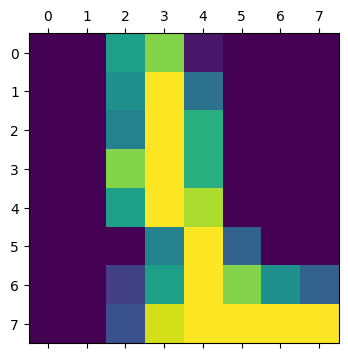

In [3]:
# Checks the digit obtained as the "one" vector.
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 4)

plt.matshow(one.reshape(8,8))
plt.show()

### Encoding with Qiskit

Depth 115
Gate count [('u', 63), ('cx', 57)]


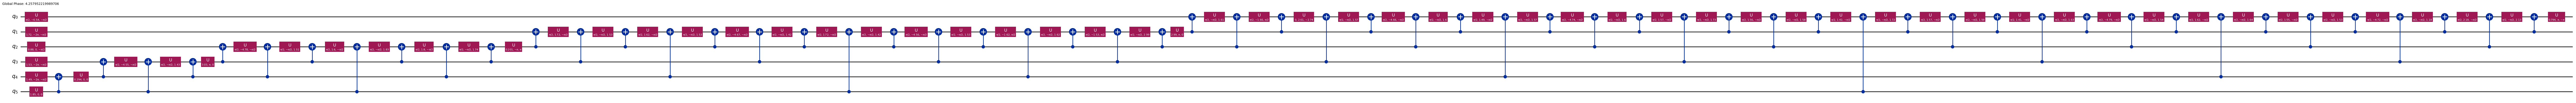

In [4]:
from qiskit.circuit.library import StatePreparation

instr1 = StatePreparation(
    params=one.tolist()
)
circuit1 = instr1.definition.decompose(reps=3)

print('Depth', circuit1.depth())
print('Gate count', list(circuit1.count_ops().items()))
circuit1.draw('mpl', fold=-1)

### Encoding with q-alchemy

Depth 15
Gate count [('u', 49), ('cx', 17)]


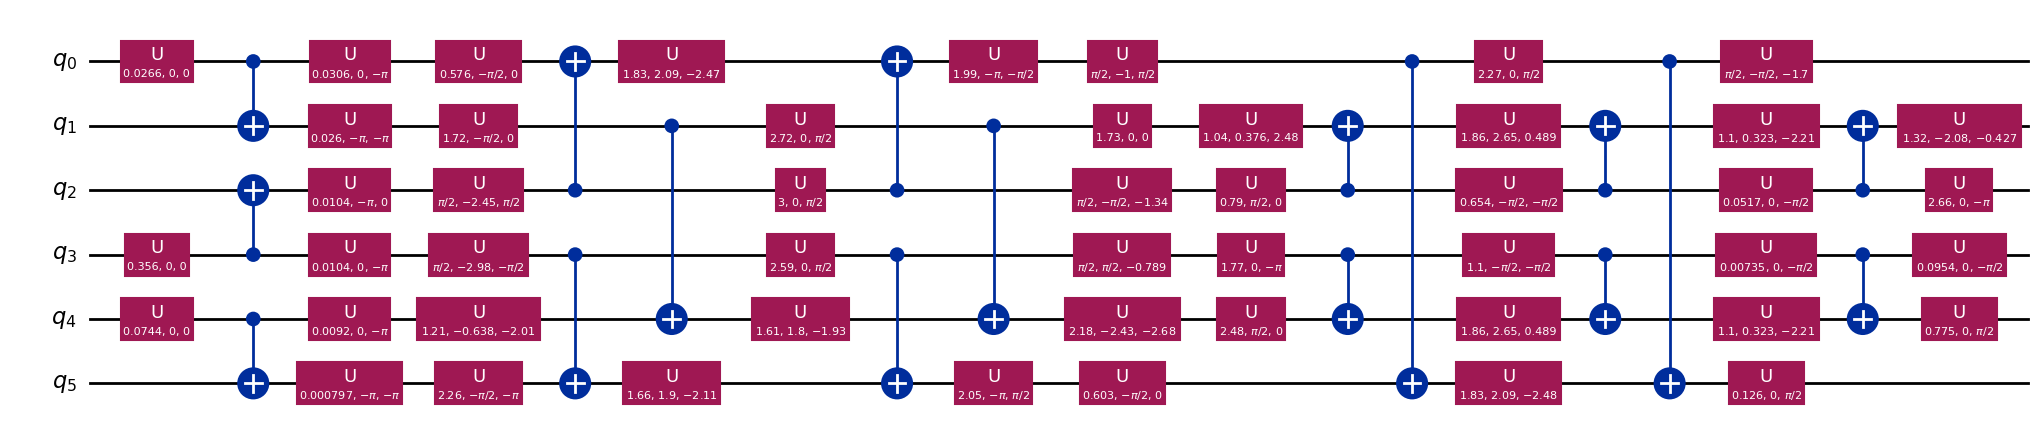

In [ ]:
from q_alchemy.qiskit_integration import QAlchemyInitialize, OptParams

instr2 = QAlchemyInitialize(
    params=one.tolist(),
    opt_params=OptParams(
        max_fidelity_loss=0.1,
        basis_gates=['u', 'cx'],
        api_key=""
    )
)
circuit2 = instr2.definition

print('Depth', circuit2.depth())
print('Gate count', list(circuit2.count_ops().items()))
circuit2.draw('mpl', fold=-1)

### Let's check if the encoding is correct.

Qiskit:


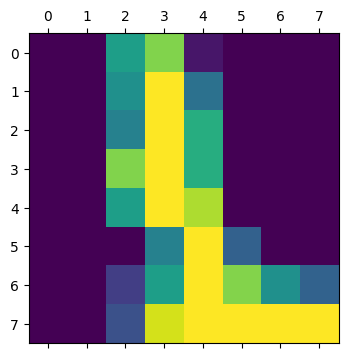

Q-Alchemy:


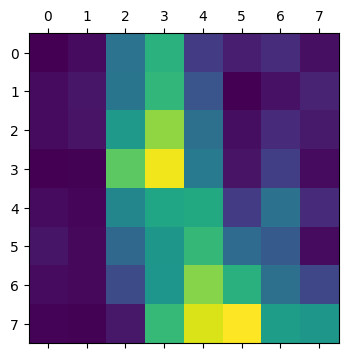

In [6]:
from qiskit.quantum_info import Statevector

def check_encoded_data(circuit):
    state_vector = Statevector(circuit)
    plt.matshow(np.abs(state_vector.data).reshape(8,8))
    plt.show()

print('Qiskit:')
check_encoded_data(circuit1)
print('Q-Alchemy:')
check_encoded_data(circuit2)

### Noiseless experiment

In [7]:
from qiskit.quantum_info import state_fidelity
from qiskit_experiments.library import StateTomography
from qiskit_aer import AerSimulator

def noiseless_experiment1(circuit):
    backend = AerSimulator()

    qst = StateTomography(circuit, backend)
    qstdata = qst.run(backend, seed_simulation=42, shots=8192).block_for_results()

    rho = qstdata.analysis_results("state").value

    return state_fidelity(rho, one)


print('Fidelity Qiskit:', noiseless_experiment1(circuit1))
print('Fidelity Q-Alchemy:', noiseless_experiment1(circuit2))

Fidelity Qiskit: 0.9916253399312283
Fidelity Q-Alchemy: 0.9028293706407728


### Noisy experiment

In [8]:
from qiskit.quantum_info import state_fidelity
from qiskit_experiments.library import StateTomography
from qiskit_ibm_runtime.fake_provider import FakePerth

def noisy_experiment1(circuit):
    noisy_backend = FakePerth()

    qst = StateTomography(circuit, noisy_backend)
    qstdata = qst.run(noisy_backend, seed_simulation=42, shots=8192).block_for_results()

    rho = qstdata.analysis_results("state").value

    return state_fidelity(rho, one)


print('Fidelity Qiskit:', noisy_experiment1(circuit1))
print('Fidelity Q-Alchemy:', noisy_experiment1(circuit2))

Fidelity Qiskit: 0.19381345650618942
Fidelity Q-Alchemy: 0.5149261580522417


### Yet another noisy experiment

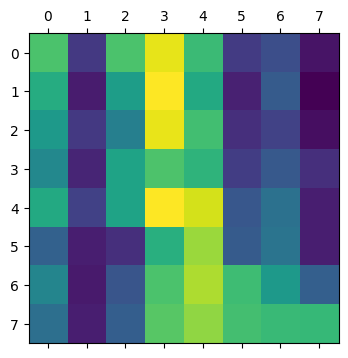

Fidelity Qiskit: 0.6491970160464


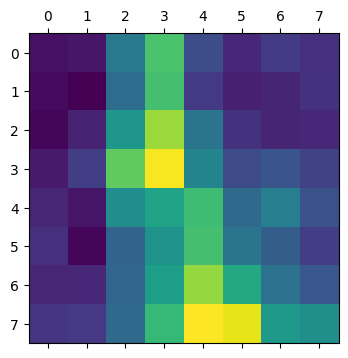

Fidelity Q-Alchemy: 0.7917330771207852


In [9]:
from qiskit import transpile

def noisy_experiment2(circuit):
    mcircuit = circuit.measure_all(inplace=False)

    noisy_backend = FakePerth()

    # Transpile the circuit for the noisy basis gates
    tcircuit = transpile(mcircuit, noisy_backend, optimization_level=0)

    # Execute noisy simulation and get counts
    result = noisy_backend.run(tcircuit, shots=8192).result()
    counts = result.get_counts(0)

    # Pad with zeroes
    counts = np.array([counts.get(f'{i:06b}', 0) for i in range(64)])
    
    probs = counts / sum(counts)
    state_vector_estimation = np.sqrt(probs)

    # Plot the figure from the measurement probabilities.
    plt.matshow(state_vector_estimation.reshape(8,8))
    plt.show()

    return(state_fidelity(one, state_vector_estimation))


print('Fidelity Qiskit:', noisy_experiment2(circuit1))
print('Fidelity Q-Alchemy:', noisy_experiment2(circuit2))